In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

In [10]:
pm.__version__

'3.11.4'

In [2]:
np.random.seed(12345)

n = 50
x = np.linspace(0, 1, n)
X = x.reshape(-1,1)

nugget = 0.75
sigma2_true = 4.0
l_true = 10

cov_func = sigma2_true * pm.gp.cov.ExpQuad(1, 1/l_true)
mean_func = pm.gp.mean.Zero()

y_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval(), 1
).flatten()

y = y_true + nugget * np.random.randn(n)

with pm.Model() as gp_marginal:
  nugget = pm.HalfCauchy("nugget", beta=5)
  sigma2 = pm.HalfCauchy("sigma2", beta=5)
  l      = pm.HalfCauchy("l",      beta=5)

  cov = sigma2 * pm.gp.cov.ExpQuad(input_dim=1, ls=1/l)
  gp = pm.gp.Marginal(cov_func=cov)

  y_ = gp.marginal_likelihood("y", X=X, y=y, noise=nugget)

with gp_marginal:
    step = pm.NUTS([nugget, sigma2, l])
    trace = pm.sample(
        return_inferencedata = True, chains = 2, step = step
    )

    mp = pm.find_MAP()

X_pred = np.linspace(0, 1, 1000)[:, None]

with gp_marginal:
    y_pred = gp.conditional("y_pred", X_pred)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [l, sigma2, nugget]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8845697489972615, but should be close to 0.8. Try to increase the number of tuning steps.


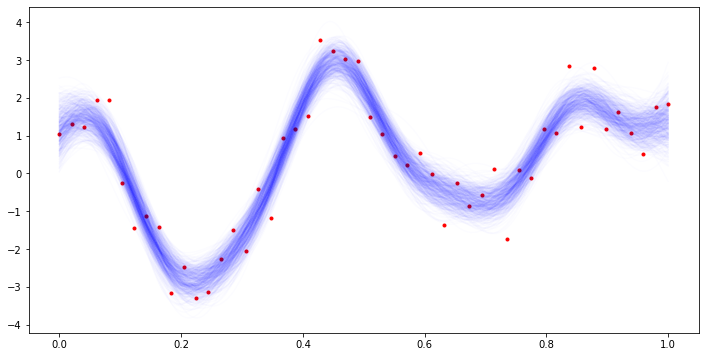

In [3]:
with gp_marginal:
    pp = pm.sample_posterior_predictive([mp], var_names=["y_pred"], samples=500)

plt.figure(figsize=(12,6))
plt.plot(x,y,".r")
lines = plt.plot(X_pred, pp["y_pred"].T, '-b', alpha=0.01)

In [4]:
with gp_marginal:
    #pp = pm.sample_posterior_predictive([trace], var_names=["y_pred"], samples=500)
    pp = pm.sample_posterior_predictive(trace, var_names=["y_pred"], samples=500)
    
with gp_marginal:
    pp2 = pm.sample_posterior_predictive(trace, var_names=["y_pred"], samples=500, keep_size=False)

/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/.dcm/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


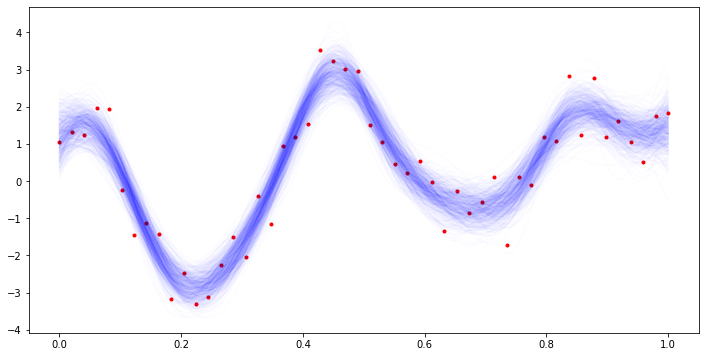

In [5]:
plt.figure(figsize=(12,6))
plt.plot(x,y,".r")
lines = plt.plot(X_pred, pp["y_pred"].T, '-b', alpha=0.01)

In [6]:
pp["y_pred"].shape, pp["y_pred"].squeeze().shape, pp2["y_pred"].squeeze().shape

((500, 1000), (500, 1000), (500, 1000))

(-5.0, 5.0)

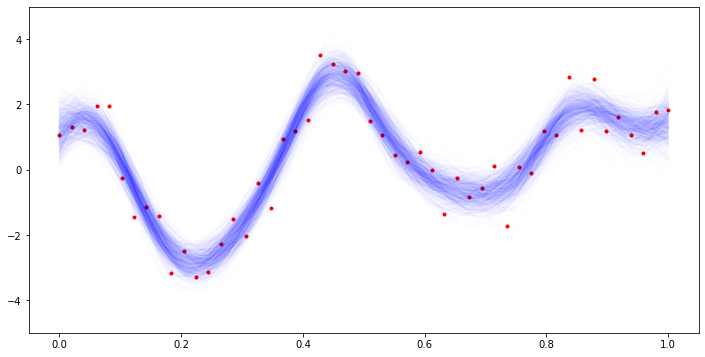

In [7]:
plt.figure(figsize=(12,6))
plt.plot(x,y,".r")
lines = plt.plot(X_pred, pp["y_pred"].T, '-b', alpha=0.01)
plt.ylim((-5,5))

In [8]:
pp2

{'y_pred': array([[0.28671457, 0.33110458, 0.37959991, ..., 1.37509753, 1.38087851,
         1.38294436],
        [1.42506181, 1.42981918, 1.43428028, ..., 1.34446906, 1.35117813,
         1.35942474],
        [1.98675663, 1.98295717, 1.97834499, ..., 1.70520238, 1.7041528 ,
         1.70369401],
        ...,
        [1.51013244, 1.49247037, 1.47359109, ..., 1.40024244, 1.39742924,
         1.39553213],
        [1.05447919, 1.07584619, 1.10021175, ..., 1.57608237, 1.58106488,
         1.58869779],
        [1.81855077, 1.82400701, 1.831858  , ..., 1.11576565, 1.10505315,
         1.09409449]])}

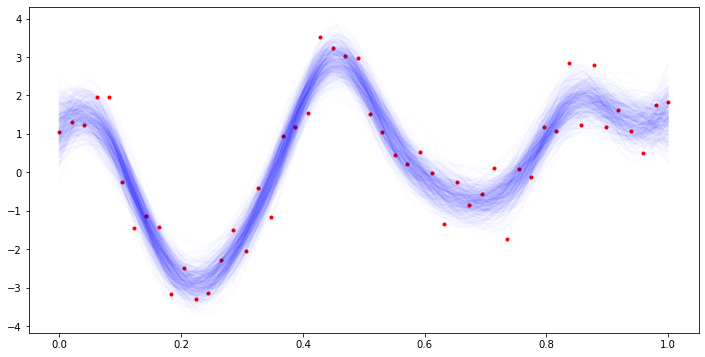

In [9]:
plt.figure(figsize=(12,6))
plt.plot(x,y,".r")
lines = plt.plot(X_pred, pp2["y_pred"].squeeze().T, '-b', alpha=0.01)